<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_equalizers_for_IMDD_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test equalizers for IM-DD transmission systems

In [37]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [38]:
import numpy as np
from optic.models.tx import pamTransmitter
from optic.models.devices import photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.metrics import fastBERcalc
from optic.dsp.core import pnorm, signalPower, movingAverage   
from optic.dsp.equalization import dfe, ffe
from optic.utils import parameters
from optic.plot import eyediagram

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [39]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [40]:
figsize(10, 3)

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Intensity modulation (IM) with Pulse Amplitude Modulation (PAM)

Average power of the modulated optical signal [dBm]: -3.000 dBm


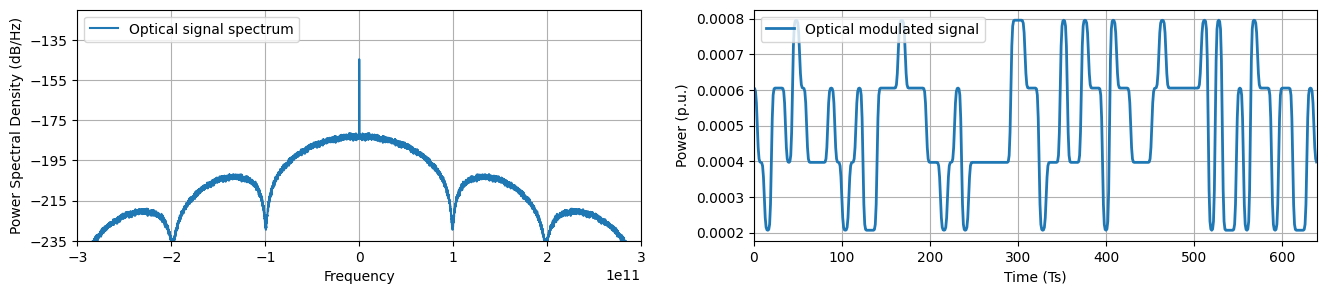

In [42]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9         # symbol rate
paramTx.SpS = 8            # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

sigTxo, symbTx = pamTransmitter(paramTx)

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signalPower(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*paramTx.Rs,3*paramTx.Rs);
axs[0].set_ylim(-235,-120);
axs[0].psd(np.abs(sigTxo)**2, Fs=paramTx.SpS*paramTx.Rs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

interval = np.arange(0, len(sigTxo), 1)
axs[1].plot(np.abs(sigTxo[0:80*paramTx.SpS])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (Ts)')
axs[1].set_xlim(0, 80*paramTx.SpS)
axs[1].legend(loc='upper left')
axs[1].grid()

### Linear fiber channel model (fiber + EDFA opt. amplifier)

In [43]:
# linear optical channel
paramCh = parameters()
paramCh.L = 1.2          # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 17         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

# receiver pre-amplifier
paramEDFA = parameters()
paramEDFA.G = paramCh.α*paramCh.L    # edfa gain
paramEDFA.NF = 4.5   # edfa noise figure 
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs
paramEDFA.seed = 789

sigCh = edfa(sigCh, paramEDFA)

### Direct-detection (DD) pin receiver model

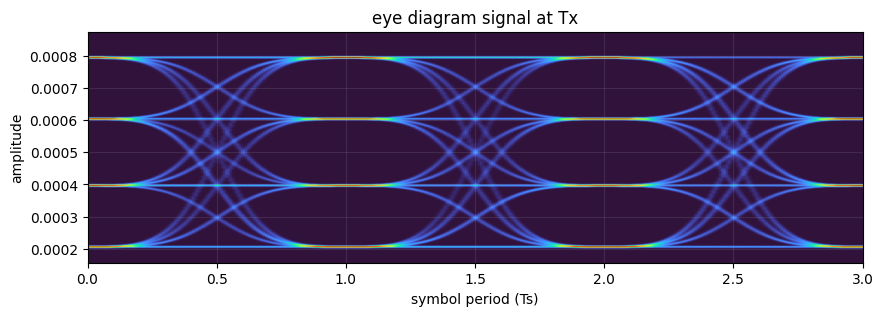

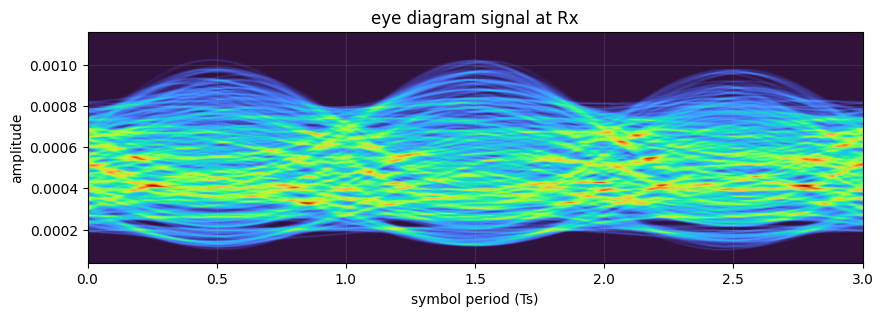

In [44]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs
paramPD.seed = 456
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

I_Rx = photodiode(sigCh, paramPD)

discard = 100*paramTx.SpS
eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, paramTx.SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, paramTx.SpS, plotlabel='signal at Rx', ptype='fancy')

In [45]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
symbRx = I_Rx[0::paramTx.SpS]

# subtract DC level and normalize power
symbRx = symbRx - symbRx.mean()
symbRx = pnorm(symbRx)


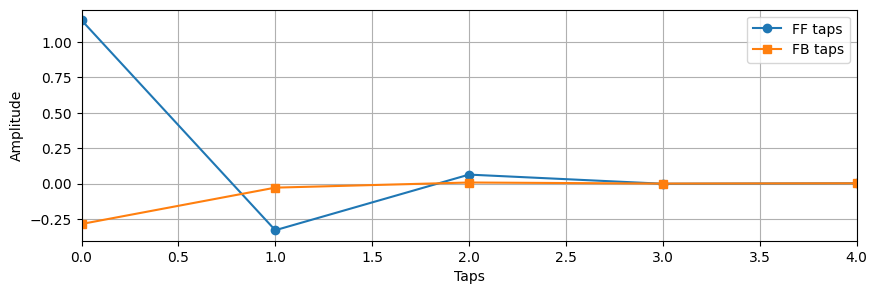

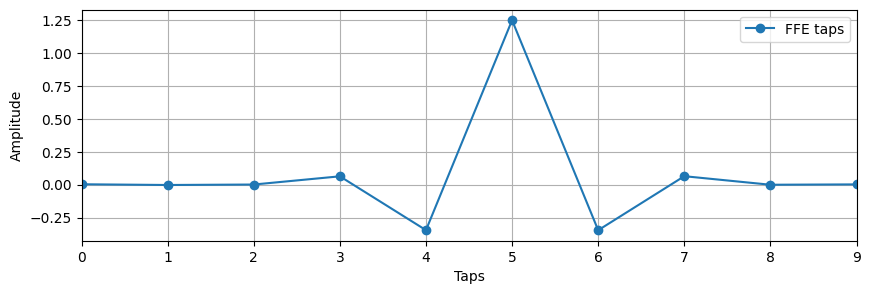

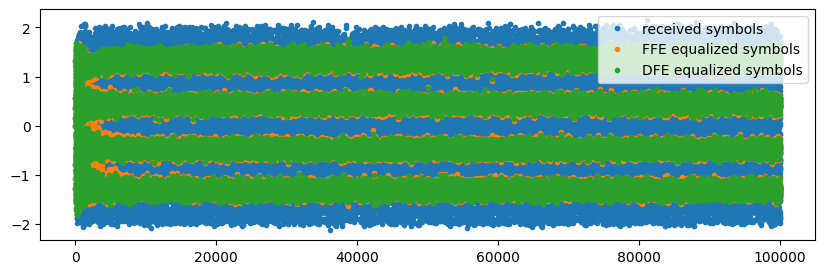

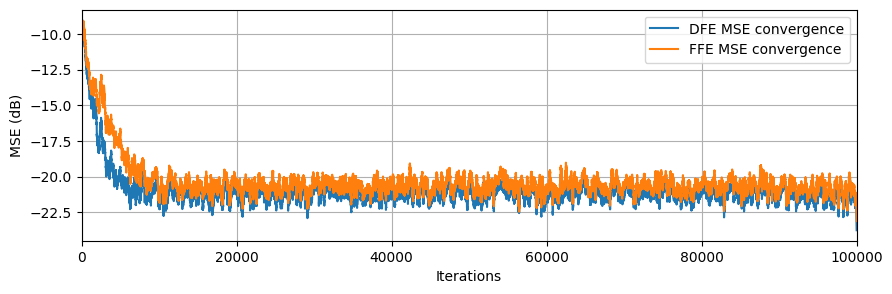

In [54]:
# Apply DFE equalization
paramDFE = parameters()
paramDFE.nTapsFF = 5
paramDFE.nTapsFB = 5
paramDFE.mu = 1e-3
paramDFE.ntrain = 4000
paramDFE.M = paramTx.M

outDFE, f, b, mseDFE = dfe(symbRx, symbTx.astype(np.float32), paramDFE)
outDFE = pnorm(outDFE)


plt.figure(figsize=(10,3))
plt.plot(f, 'o-', label='FF taps')
plt.plot(b, 's-', label='FB taps')
plt.xlim(0, max(len(f), len(b))-1)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

# Apply ffe equalization
paramFFE = parameters()
paramFFE.nTaps = 10
paramFFE.mu = 1e-3
paramFFE.ntrain = 1000

outFFE, h, mseFFE = ffe(symbRx, symbTx, paramFFE)

plt.figure(figsize=(10,3))
plt.plot(h, 'o-', label='FFE taps')
plt.legend()
plt.xlim(0, len(h)-1)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.grid()

plt.figure(figsize=(10,3))
plt.plot(symbRx,'.', label='received symbols')
plt.plot(outFFE,'.', label='FFE equalized symbols')
plt.plot(outDFE,'.', label='DFE equalized symbols')
plt.legend()

plt.figure(figsize=(10,3))
plt.plot(10*np.log10(movingAverage(mseDFE, 200)), label='DFE MSE convergence')
plt.plot(10*np.log10(movingAverage(mseFFE, 200)), label='FFE MSE convergence')
plt.legend()
plt.xlim(0, len(mseDFE))
plt.xlabel('Iterations')
plt.ylabel('MSE (dB)')
plt.grid()


In [55]:
# demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR

# without equalization
discard = 5000
ber, ser, snr = fastBERcalc(symbRx[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')

# with FFE equalization
ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')

# with DFE equalization
ber_dfe, ser_dfe, snr_dfe = fastBERcalc(outDFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')

# print results table
print('Performance results:')
print('------------------------------------')
print('Method      |  BER       |  SNR (dB)')
print('------------------------------------')
print(f'No EQ       |  {ber[0]:.2e}  |  {snr[0]:.2f} ')
print(f'FFE         |  {ber_ffe[0]:.2e}  |  {snr_ffe[0]:.2f} ')
print(f'DFE         |  {ber_dfe[0]:.2e}  |  {snr_dfe[0]:.2f} ') 

Performance results:
------------------------------------
Method      |  BER       |  SNR (dB)
------------------------------------
No EQ       |  1.11e-01  |  8.53 
FFE         |  5.56e-06  |  20.54 
DFE         |  0.00e+00  |  21.15 


### Generate curve of BER vs received input power

In [32]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9          # symbol rate
paramTx.SpS = 16           # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e6) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

powerValues = np.arange(-20,-4) # power values at the input of the pin receiver
ber = np.zeros(powerValues.shape)
ber_wFFE = np.zeros(powerValues.shape)
ber_wDFE = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)
    
discard = 100
for indPi, Pi_dBm in enumerate(tqdm(powerValues)):
    
    paramTx.power = Pi_dBm # optical signal power at the MZM output

    # generate PAM modulated signal
    sigTxo, symbTx = pamTransmitter(paramTx)

    # pin receiver
    I_Rx = photodiode(sigTxo.real, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    symbRx = I_Rx[0::paramTx.SpS]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)

    # Apply DFE equalization
    paramDFE = parameters()
    paramDFE.nTapsFF = 5
    paramDFE.nTapsFB = 5
    paramDFE.mu = 1e-3
    paramDFE.ntrain = 4000
    paramDFE.M = paramTx.M

    outDFE,f, b,mseDFE = dfe(symbRx, symbTx.astype(np.float32), paramDFE)
    outDFE = pnorm(outDFE)

    # Apply ffe equalization
    paramFFE = parameters()
    paramFFE.nTaps = 10
    paramFFE.mu = 1e-3
    paramFFE.ntrain = 1000  

    outFFE, h, mseFFE = ffe(symbRx, symbTx, paramFFE)

    # demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR
    discard = 1000
    # without equalization
    ber_, ser, snr = fastBERcalc(symbRx[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam') 
    ber[indPi] = ber_[0]

    # with FFE equalization
    ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')
    ber_wFFE[indPi] = ber_ffe[0]

    # with DFE equalization
    ber_eq, ser_eq, snr_eq = fastBERcalc(outDFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')
    ber_wDFE[indPi] = ber_eq[0]

  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\edson\AppData\Local\Temp\ipykernel_21732\1144918922.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber),'o-',label='BER')
C:\Users\edson\AppData\Local\Temp\ipykernel_21732\1144918922.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber_wDFE),'s-',label='BER with DFE')
C:\Users\edson\AppData\Local\Temp\ipykernel_21732\1144918922.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(ber_wFFE),'d-',label='BER with FFE')


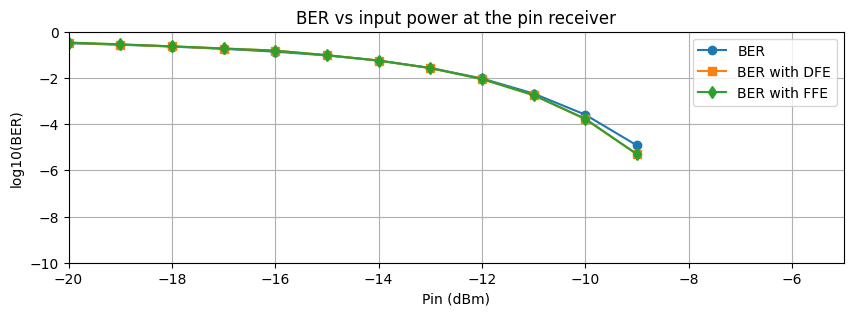

In [33]:
plt.figure()
plt.plot(powerValues, np.log10(ber),'o-',label='BER')
plt.plot(powerValues, np.log10(ber_wDFE),'s-',label='BER with DFE')
plt.plot(powerValues, np.log10(ber_wFFE),'d-',label='BER with FFE')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Pin (dBm)');
plt.title('BER vs input power at the pin receiver')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(powerValues), max(powerValues));

### Generate curve of BER vs transmission distance

In [ ]:
# simulation parameters
paramTx = parameters()
paramTx.M = 4              # modulation order
paramTx.Rs = 100e9          # symbol rate
paramTx.SpS = 16           # samples per symbol
paramTx.seed = 123         # seed for the random number generator
paramTx.nBits = int(np.log2(paramTx.M)*1e6) # total number of bits to transmit
paramTx.pulseType = 'nrz'  # pulse shape type
paramTx.power = -3         # optical output power in dBm
paramTx.mzmScale = 0.20    # MZM modulation scale factor Vrf/Vpi

Fs = paramTx.SpS * paramTx.Rs  # simulation sampling frequency

# fiber channel parameters
distance = np.arange(0.8, 2.1, 0.1) # transmission distance in km
paramCh = parameters()
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# receiver pre-amplifier parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5   # edfa noise figure 
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs
paramEDFA.seed = 789

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramTx.Rs
paramPD.Fs = Fs
paramPD.seed = 456

ber = np.zeros(distance.shape)
ber_wFFE = np.zeros(distance.shape)
ber_wDFE = np.zeros(distance.shape)
Pb = np.zeros(distance.shape)

# generate PAM modulated signal
sigTxo, symbTx = pamTransmitter(paramTx)

for indL, L in enumerate(tqdm(distance)):         
    # linear optical channel   
    paramCh.L = L
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # receiver pre-amplifier
    if L > 0:
        paramEDFA.G = paramCh.α*L  # edfa gain       
        sigCh = edfa(sigCh, paramEDFA)

    # pin receiver
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    symbRx = I_Rx[0::paramTx.SpS]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)

    # Apply FFE equalization
    paramFFE = parameters()
    paramFFE.nTaps = 10
    paramFFE.mu = 1e-3
    paramFFE.ntrain = 4000
    paramFFE.M = paramTx.M

    outFFE, h, mse = ffe(symbRx, symbTx, paramFFE)
    outFFE = pnorm(outFFE)

    # Apply DFE equalization
    paramDFE = parameters()
    paramDFE.nTapsFF = 5
    paramDFE.nTapsFB = 5
    paramDFE.mu = 1e-3
    paramDFE.ntrain = 4000
    paramDFE.M = paramTx.M

    outDFE,f, b, mse = dfe(symbRx, symbTx, paramDFE)
    outDFE = pnorm(outDFE)
    
    # demodulate symbols to bits with minimum Euclidean distance and calculated BER, SER and SNR
    discard = 4000

    # without equalization  
    ber_, ser, snr = fastBERcalc(symbRx[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam') 
    ber[indL] = ber_[0]

    # with FFE equalization
    ber_ffe, ser_ffe, snr_ffe = fastBERcalc(outFFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')
    ber_wFFE[indL] = ber_ffe[0]

    # with DFE equalization
    ber_eq, ser_eq, snr_eq = fastBERcalc(outDFE[discard:-discard], symbTx[discard:-discard], paramTx.M, 'pam')
    ber_wDFE[indL] = ber_eq[0]

  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\edson\AppData\Local\Temp\ipykernel_21732\1132524092.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(ber_wFFE),'d-',label='BER with FFE')
C:\Users\edson\AppData\Local\Temp\ipykernel_21732\1132524092.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(ber_wDFE),'s-',label='BER with DFE')


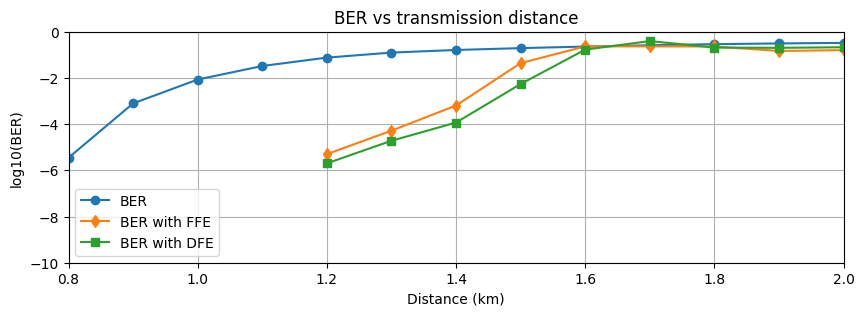

In [36]:
plt.figure()
plt.plot(distance, np.log10(ber),'o-',label='BER')
plt.plot(distance, np.log10(ber_wFFE),'d-',label='BER with FFE')
plt.plot(distance, np.log10(ber_wDFE),'s-',label='BER with DFE')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Distance (km)');
plt.title('BER vs transmission distance')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(distance), max(distance));